# Citations

This notebook uses the Beijing PM2.5 Data Data Set downloaded from the UCI Machine Learning Repository:
https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

**Dataset citation:**
Liang, X., Zou, T., Guo, B., Li, S., Zhang, H., Zhang, S., Huang, H. and Chen, S. X. (2015). Assessing Beijing's PM2.5 pollution: severity, weather impact, APEC and winter heating. Proceedings of the Royal Society A, 471, 20150257.

**UCI Machine Learning Repository citation:**
re3data.org: UCI Machine Learning Repository; editing status 2017-10-30; re3data.org - Registry of Research Data Repositories. http://doi.org/10.17616/R3T91Q last accessed: 2020-12-20

# General Setup

In [ ]:
!pip install scipy sklearn pandas 'torch-lr-finder==0.2.0'
# !rm -vrf '/tobit_loss'
!git clone https://github.com/vlad-danaila/tobit_loss.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'tobit_loss' already exists and is not an empty directory.


Add the Tobit loss to Python path.

In [ ]:
import sys
sys.path.insert(0, './tobit_loss')

Imports

In [ ]:
import torch as t
from deep_tobit.util import to_torch, to_numpy, normalize, unnormalize
from deep_tobit.normal_cumulative_distribution_function import cdf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import random
import sklearn as sk
import sklearn.metrics
import math
from sklearn.model_selection import ParameterGrid
from torch_lr_finder import LRFinder, TrainDataLoaderIter, ValDataLoaderIter
import os
import numpy.random
import collections
import pandas as pd
import requests
import sklearn.decomposition
import traceback
from scipy.stats import norm

Constants

In [ ]:
URL_BEIJING_PM_2_5_DATA_SET = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'
DATASET_FILE = 'Beijing PM2.5 dataset.csv'
CHECKPOINT_MAE = 'mae model'
CHECKPOINT_BOUNDED_MAE = 'mae bounded model'
CHECKPOINT_BOUNDED_MAE_WITH_PENALTY = 'mae bounded with penalty model'
CENSOR_LOW_BOUND = 75
CENSOR_HIGH_BOUND = 300
LAYER_SIZE = 10
BINS_LEN = 100
CHECKPOINT_FREQUENCY = 10

GRID_RESULTS_FILE = 'grid_results.tar'

CUDA = t.cuda.is_available()

Reproducible experiments

In [ ]:
SEED = 0
t.manual_seed(SEED)
t.cuda.manual_seed(SEED)
t.cuda.manual_seed_all(SEED)
t.backends.cudnn.deterministic = True
t.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

# Model

In [ ]:
class DenseNetwork(t.nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_in = t.nn.Linear(46, LAYER_SIZE)
    self.norm_1 = t.nn.BatchNorm1d(LAYER_SIZE, affine = False, momentum = None)
    self.drop_1 = t.nn.Dropout(p = .2)
    self.layer_hidden_1 = t.nn.Linear(LAYER_SIZE, LAYER_SIZE)
    self.norm_2 = t.nn.BatchNorm1d(LAYER_SIZE, affine = False, momentum = None)
    self.drop_2 = t.nn.Dropout(p = .2)
    self.layer_out = t.nn.Linear(LAYER_SIZE, 1)

  def forward(self, x):
    x = t.nn.functional.relu(self.norm_1(self.layer_in(x)))
    x = self.drop_1(x)
    x = t.nn.functional.relu(self.norm_2(self.layer_hidden_1(x)))
    x = self.drop_2(x)
    x = self.layer_out(x)
    return x

In [ ]:
def get_model(cuda = CUDA, net = None):  
  if net == None:
    net = DenseNetwork()
  if cuda:
    net = net.cuda()
  net = t.nn.DataParallel(net)
  return net

def get_device(cuda = CUDA):
  return 'cuda:0' if cuda else 'cpu'

def get_gamma(cuda = CUDA):
  gamma = t.tensor(1., requires_grad = True, device = get_device())
  return gamma

# Datasets

In [ ]:
r = requests.get(URL_BEIJING_PM_2_5_DATA_SET, allow_redirects=True)
open(DATASET_FILE, 'wb').write(r.content)

2010494

In [ ]:
def load_dataframe(filter_null = True):
  df = pd.read_csv(DATASET_FILE)
  # exclude records without a measured pm2.5
  if filter_null:
    df = df[df['pm2.5'].notnull()]
  return df

In [ ]:
df = load_dataframe()

In [ ]:
def train_df(df: pd.DataFrame):
  return df[ df.year.isin([2010, 2011, 2012]) ]

def val_df(df: pd.DataFrame):
  return df[ df.year.isin([2013]) ]

def test_df(df: pd.DataFrame):
  return df[ df.year.isin([2014]) ]

In [ ]:
def y_train_mean_std(max_iterations = 10_000, early_stop_patience = 5, lr = 1e-6, epsilon = 1e-6):
  df = train_df(load_dataframe())
  ys = df['pm2.5'].values

  real_mean, real_std = ys.mean(), ys.std()

  y_single_valued, y_left_censored, y_right_censored = [], [], []
  
  for y in ys:
    if y > CENSOR_LOW_BOUND and y < CENSOR_HIGH_BOUND:
      y_single_valued.append(y)
    elif y <= CENSOR_LOW_BOUND:
      y_left_censored.append(CENSOR_LOW_BOUND)
    elif y >= CENSOR_HIGH_BOUND:
      y_right_censored.append(CENSOR_HIGH_BOUND)
    else:
      raise Exception('y outside of valid values, y = {}'.format(y[0]))

  all = np.array(y_single_valued + y_left_censored + y_right_censored)
  data_mean, data_std = all.mean(), all.std()

  return data_mean.item(), data_std.item()

y_mean, y_std = y_train_mean_std()
print(f'mean = {y_mean}; std = {y_std}')

mean = 115.89409452043574; std = 63.0676161648441


In [ ]:
bound_min = normalize(CENSOR_LOW_BOUND, y_mean, y_std)
bound_max = normalize(CENSOR_HIGH_BOUND, y_mean, y_std)
zero_normalized = normalize(0, y_mean, y_std)

In [ ]:
numeric_features_column_names = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']

In [ ]:
def x_numeric_fatures_train_mean_std():
  df = train_df(load_dataframe())
  numeric_fetures = df[numeric_features_column_names].values
  mean, std = numeric_fetures.mean(axis = 0), numeric_fetures.std(axis = 0)
  return mean, std

x_numeric_fetures_mean, x_numeric_fetures_std = x_numeric_fatures_train_mean_std()

In [ ]:
def extract_features(df: pd.DataFrame, lower_bound = -math.inf, upper_bound = math.inf):
  assert lower_bound <= upper_bound
  # handle categorical features (one hot encoding)
  one_hot = sk.preprocessing.OneHotEncoder(sparse = False)
  month_one_hot = one_hot.fit_transform(np.expand_dims(df['month'].values, 1))
  # day_one_hot = one_hot.fit_transform(np.expand_dims(df['day'].values, 1))
  hour_one_hot = one_hot.fit_transform(np.expand_dims(df['hour'].values, 1))
  combined_wind_direction_one_hot = one_hot.fit_transform(np.expand_dims(df['cbwd'].values, 1))
  
  # extract the numeric variables
  numeric_fetures = df[numeric_features_column_names].values
  numeric_fetures = normalize(numeric_fetures, x_numeric_fetures_mean, x_numeric_fetures_std)

  # unite all features
  x = np.hstack((month_one_hot, hour_one_hot, combined_wind_direction_one_hot, numeric_fetures))

  # extract the results
  y = df['pm2.5'].values
  y = np.clip(y, lower_bound, upper_bound)
  y = normalize(y, y_mean, y_std)
  y = np.expand_dims(y, 1)

  return x, y

In [ ]:
class PM_2_5_Dataset(t.utils.data.Dataset):
  
  def __init__(self, x: np.array, y: np.array, cuda = CUDA):
    super().__init__()
    self.x = t.tensor(x, requires_grad = True, dtype=t.float32)
    self.y = t.tensor(y, requires_grad = True, dtype=t.float32)
    if cuda:
      self.x = self.x.cuda()
      self.y = self.y.cuda()
    
  def __getitem__(self, i):
    return self.x[i], self.y[i]

  def __len__(self):
    return len(self.y)

In [ ]:
def parse_datasets():
  df = load_dataframe()
  
  # split into training / validation / test
  df_train = train_df(df)
  df_val = val_df(df)
  df_test = test_df(df)

  dataset_train = PM_2_5_Dataset(*extract_features(df_train, lower_bound = CENSOR_LOW_BOUND, upper_bound = CENSOR_HIGH_BOUND))
  dataset_val = PM_2_5_Dataset(*extract_features(df_val, lower_bound = CENSOR_LOW_BOUND, upper_bound = CENSOR_HIGH_BOUND))
  dataset_test = PM_2_5_Dataset(*extract_features(df_test))

  return dataset_train, dataset_val, dataset_test

dataset_train, dataset_val, dataset_test = parse_datasets()

In [ ]:
def pca(x, n_components = 1):
  pca_encoder = sk.decomposition.PCA(n_components = n_components)
  return pca_encoder.fit_transform(x)

# Plotting

In [ ]:
def plot_full_dataset(df: pd.DataFrame, size = 0.01, label = None, censored = False):
  if censored:
    x, y = extract_features(df, lower_bound = CENSOR_LOW_BOUND, upper_bound = CENSOR_HIGH_BOUND)
  else:
    x, y = extract_features(df)
  x = pca(x)
  if not censored:
    min_max = [min(x), max(x)]
    plt.plot(min_max, [bound_min] * 2, color = 'red')
    plt.plot(min_max, [bound_max] * 2, color = 'red')
    plt.plot(min_max, [zero_normalized] * 2, color = 'red')
  plt.scatter(x, y, s = size, label = label)
  plt.xlabel('unidimensional PCA')
  plt.ylabel('PM2.5 (standardized)')
  # plt.savefig(label + '.pdf', dpi = 300, format = 'pdf')

In [ ]:
LOSS = 0
ABS_ERR = 1
R_SQUARED = 2

In [ ]:
def plot_train_test(train, test, title, y_title):
    plt.plot(range(len(train)), train, label = 'Train')
    plt.plot(range(len(test)), test, label = 'Test')
    plt.xlabel('Epochs')
    plt.ylabel(y_title)
    plt.title(title)
    plt.legend()
    # plt.savefig(title + '.png', dpi = 300, format = 'png')
    plt.show()

In [ ]:
def plot_epochs(train_metrics_list, test_metrics_list):
  test_r2 = list(map(lambda m: m[R_SQUARED], test_metrics_list))
  test_err = list(map(lambda m: m[ABS_ERR], test_metrics_list))
  test_loss = list(map(lambda m: m[LOSS], test_metrics_list))
  train_r2 = list(map(lambda m: m[R_SQUARED], train_metrics_list))
  train_err = list(map(lambda m: m[ABS_ERR], train_metrics_list))
  train_loss = list(map(lambda m: m[LOSS], train_metrics_list))
  plot_train_test(train_loss, test_loss, 'Loss', 'Loss')
  plot_train_test(train_err, test_err, 'Absolute error', 'Absolute error')
  plot_train_test(train_r2, test_r2, 'R squared', 'R squared')

In [ ]:
def plot_net(model, df: pd.DataFrame, label = 'model prediction', with_std = False):
  model.eval()
  x, y_real = extract_features(df)
  x_pca = pca(x)
  dataset = PM_2_5_Dataset(x, y_real)
  y_list = []
  for i in range(len(dataset)):
    x, _ = dataset[i]
    y_pred = model.forward(x.reshape(1, -1))
    y_list.append(y_pred[0].item())
  plt.scatter(x_pca, y_list, s = .1, label = label)

# Training

In [ ]:
# n is the nb of samples, k is the nb of regressors (features)
n = len(dataset_train)
k = len(dataset_train[0][0])
print(f'While calculating the adjusted R2, n = {n} and k = {k}')

def adjusted_R2(y, y_pred):
  r2 = sk.metrics.r2_score(y, y_pred)
  return 1 - ( ( (1 - r2) * (n - 1) ) / (n - k - 1) )

While calculating the adjusted R2, n = 24418 and k = 46


In [ ]:
def eval_network(model, loader, loss_fn, batch_size, is_eval_bounded = True):
  model.eval()
  with t.no_grad():
    metrics = np.zeros(3)
    total_weight = 0
    for x, y in loader:
      y_pred = model.forward(x)
      loss = loss_fn(y_pred, y)
      if is_eval_bounded:
        y_pred = t.clamp(y_pred, min = bound_min, max = bound_max)
      y_pred, y = to_numpy(y_pred), to_numpy(y)
      weight = len(y) / batch_size
      metrics[LOSS] += (loss.item() * weight)
      metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
      metrics[R_SQUARED] += (adjusted_R2(y, y_pred) * weight)
      total_weight += weight
    metrics /= total_weight
    return metrics

In [ ]:
def train_network(model, loss_fn, optimizer, scheduler, loader_train, loader_val, checkpoint_name, 
                  batch_size_train, batch_size_val, epochs, log = True):
  metrics_train_per_epochs, metrics_test_per_epochs = [], []
  best = [math.inf, math.inf, -math.inf]
  try:
    counter = 0
    total_weight = 0
    train_metrics = np.zeros(3)  
    for epoch in range(epochs):    
      try:
        model.train()        
        for x, y in loader_train:
          counter += 1
          y_pred = model.forward(x)
          loss = loss_fn(y_pred, y)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          y_pred = t.clamp(y_pred, min = bound_min, max = bound_max)
          y_pred, y = to_numpy(y_pred), to_numpy(y)
          weight = len(y) / batch_size_train
          train_metrics[LOSS] += (loss.item() * weight)
          train_metrics[ABS_ERR] += (sk.metrics.mean_absolute_error(y, y_pred) * weight)
          train_metrics[R_SQUARED] += (adjusted_R2(y, y_pred) * weight)
          total_weight += weight
          scheduler.step()
          if counter % CHECKPOINT_FREQUENCY == 0:
            train_metrics /= total_weight  
            metrics_train_per_epochs.append(train_metrics)
            train_metrics = np.zeros(3)
            total_weight = 0
            test_metrics = eval_network(model, loader_val, loss_fn, batch_size_val)
            metrics_test_per_epochs.append(test_metrics)
            # if test_metrics[R_SQUARED] > best[R_SQUARED]:
            if test_metrics[ABS_ERR] < best[ABS_ERR]:  
            # if test_metrics[LOSS] < best[LOSS]: 
              best = test_metrics
              checkpoint_dict = {'model': model.state_dict()}
              t.save(checkpoint_dict, '{}.tar'.format(checkpoint_name))
            if log:
              print('Iteration {} abs err {} R2 {}'.format(counter, test_metrics[ABS_ERR], test_metrics[R_SQUARED]))
      except:
        traceback.print_exc() 
        break
    print('Best absolute error:', best[ABS_ERR], 'R2:', best[R_SQUARED])
    return metrics_train_per_epochs, metrics_test_per_epochs, best
  except KeyboardInterrupt as e:
    print('Training interrupted at epoch', epoch)

# Learning Rate Range Test Setup

In [ ]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return batch_data

class CustomValIter(ValDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return batch_data

In [ ]:
def lr_range_test_UNcensored(criterion, model = None, batch_size = 128, epochs = 5, 
    start_lr = 1e-8, end_lr = 10, log_view = True, loader_train = None, loader_val = None, plt_file_name = '', cuda = CUDA):
  try:
    if model == None:
        model = get_model()
    loss_fn = criterion()
    params = model.parameters()
    optimizer = t.optim.SGD(params, lr = start_lr)
    if not loader_train:
      loader_train = t.utils.data.DataLoader(dataset_train, batch_size, shuffle = True, num_workers = 0)
    if not loader_val:
      loader_val = t.utils.data.DataLoader(dataset_val, batch_size, shuffle = False, num_workers = 0)
    lr_finder = LRFinder(model, optimizer, loss_fn, device = get_device(cuda))
    lr_finder.range_test(loader_train, val_loader = loader_val, end_lr = end_lr, num_iter = len(loader_train) * epochs, step_mode="linear")
    lr_range_test_plot = lr_finder.plot(skip_start = 0, skip_end = 0, log_lr = log_view)
    lr_range_test_plot.figure.savefig('lr_range_test_{}.pdf'.format(plt_file_name), dpi = 300, format = 'pdf')
    lr_finder.reset()
  except:
    traceback.print_exc()

# Grid Search Setup

In [ ]:
def grid_search(grid_config, train_callback, checkpoint_name, nb_iterations = 1, conf_validation = None):
  configs = ParameterGrid(grid_config)
  configs_len = len(configs)
  counter = 0
  checkpoint_file = checkpoint_name + '.tar'
  grid_checkpoint_file = 'grid ' + checkpoint_file
  try:
    resume_grid_search = t.load(GRID_RESULTS_FILE)
  except FileNotFoundError:
    resume_grid_search = None

  results = {}
  best = [math.inf, math.inf, -math.inf]
  if resume_grid_search is not None and 'best' in resume_grid_search:
    best_conf = resume_grid_search['best']
    print('Best previous configuration', best_conf)
    best = resume_grid_search[str(best_conf)]
    print(f'Best previous metrics abs err = {best[ABS_ERR]}, R2 = {best[R_SQUARED]}')
    results = resume_grid_search

  for conf in ParameterGrid(grid_config):
    counter += 1
    
    if resume_grid_search is not None and str(conf) in resume_grid_search:
        print('Allready evaluated configuration', conf)
        continue

    if not conf_validation(conf):
      print('Skipping over configuration', conf)
      results[str(conf)] = 'invalid'
      continue
    
    print('-' * 5, 'grid search {}/{}'.format(counter, configs_len), '-' * 5)
    print('Config:', conf)
    
    best_from_iterations = [math.inf, math.inf, -math.inf]
    
    for i in range(nb_iterations):
      if nb_iterations != 1:
        print('Iteration', i + 1)
      metrics = train_callback(conf)
      
      # if metrics[R_SQUARED] > best[R_SQUARED]:
      if metrics[ABS_ERR] < best[ABS_ERR]:  
        best_from_iterations = metrics

      # if metrics[R_SQUARED] > best[R_SQUARED]:
      if metrics[ABS_ERR] < best[ABS_ERR]:  
        best = metrics
        results['best'] = conf
        if os.path.exists(grid_checkpoint_file):
          os.remove(grid_checkpoint_file)
        os.rename(checkpoint_file, grid_checkpoint_file)  
    else:
      results[str(conf)] = best_from_iterations
      t.save(results, GRID_RESULTS_FILE)
    
  return best

In [ ]:
def train_and_evaluate_UNcensored(checkpoint, criterion, model_fn = get_model, plot = False, log = True, loader_train_fn = None, loader_val_fn = None, cuda = CUDA):
  def grid_callback(conf):
    model = model_fn()
    if not loader_train_fn:
      loader_train = t.utils.data.DataLoader(dataset_train, conf['batch'], shuffle = True, num_workers = 0)
    else:
      loader_train = loader_train_fn(conf['batch'])
    if not loader_val_fn:
      loader_val = t.utils.data.DataLoader(dataset_val, len(dataset_val), shuffle = False, num_workers = 0)
    else:
      loader_val = loader_val_fn(len(dataset_val))
    loss_fn = criterion()
    params = model.parameters()
    optimizer = t.optim.SGD(params, lr = conf['max_lr'] / conf['div_factor'], momentum = conf['max_momentum'], weight_decay = conf['weight_decay'])
    scheduler = t.optim.lr_scheduler.OneCycleLR(
      optimizer, 
      max_lr = conf['max_lr'], 
      steps_per_epoch = len(loader_train), 
      epochs = conf['epochs'],
      pct_start = conf['pct_start'],
      anneal_strategy = conf['anneal_strategy'],
      base_momentum = conf['base_momentum'],
      max_momentum = conf['max_momentum'],
      div_factor = conf['div_factor'],
      final_div_factor = conf['final_div_factor']
    )
    train_metrics, val_metrics, best = train_network(
        model, loss_fn, optimizer, scheduler, loader_train, loader_val, checkpoint, conf['batch'], len(dataset_val), conf['epochs'], log = log)    
    if plot:
      plot_epochs(train_metrics, val_metrics)
    return best
  return grid_callback

In [ ]:
def config_validation(conf):
  return conf['div_factor'] <= conf['final_div_factor'] and conf['max_momentum'] >= conf['base_momentum']

# Plot Selected(With Grid) Model

In [ ]:
def plot_and_evaluate_model_UNcensored(checkpoint_name, criterion, isGrid = True, model_fn = get_model, loader_val = None):
  model = model_fn()
  checkpoint = t.load(('grid ' if isGrid else '') + checkpoint_name + '.tar')
  model.load_state_dict(checkpoint['model'])
  plot_full_dataset(test_df(df), label = 'ground truth', size = .3)
  plot_net(model, test_df(df))
  loss_fn = criterion()
  plt.xlabel('unidimensional PCA')
  plt.ylabel('PM2.5 (standardized)')
  plt.ylim((-6, 9))
  lgnd = plt.legend(loc='upper left')
  lgnd.legendHandles[0]._sizes = [10]
  lgnd.legendHandles[1]._sizes = [10]
  plt.savefig('{}.pdf'.format(checkpoint_name), dpi = 300, format = 'pdf')
  plt.savefig('{}.svg'.format(checkpoint_name), dpi = 300, format = 'svg')
  plt.savefig('{}.png'.format(checkpoint_name), dpi = 200, format = 'png')
  plt.show()

  if not loader_val:
    loader_val = t.utils.data.DataLoader(dataset_val, len(dataset_val), shuffle = False, num_workers = 0)
  val_metrics = eval_network(model, loader_val, loss_fn, len(dataset_val))
  print('Absolute error - validation', val_metrics[ABS_ERR])
  print('R2 - validation', val_metrics[R_SQUARED])

  loader_test = t.utils.data.DataLoader(dataset_test, len(dataset_test), shuffle = False, num_workers = 0)
  test_metrics = eval_network(model, loader_test, loss_fn, len(dataset_test), is_eval_bounded = False)
  print('Absolute error - test', test_metrics[ABS_ERR])
  print('R2 - test', test_metrics[R_SQUARED])

# MAE

In [ ]:
mae = t.nn.L1Loss()

def below_zero_mae_penalty(y_pred):
  y_below_zero = t.clamp(y_pred, min = -math.inf, max = zero_normalized)
  return mae(y_below_zero, t.full_like(y_below_zero, zero_normalized))

def mae_with_penalty(y_pred, y):
  return mae(y_pred, y) + below_zero_mae_penalty(y_pred)

### Learning Rate Rage Text

In [ ]:
# lr_range_test_UNcensored(t.nn.L1Loss, batch_size = 100, epochs = 1, start_lr = 1e-2, end_lr = 1e-1, log_view = False, plt_file_name = 'mae')

### Grid Search

In [ ]:
train_and_evaluate_net = train_and_evaluate_UNcensored(CHECKPOINT_MAE, t.nn.L1Loss, plot = False, log = False)

Train once with default settings

In [ ]:
# conf = {
#     'max_lr': 5e-2,
#     'epochs': 10,
#     'batch': 100,
#     'pct_start': 0.3,
#     'anneal_strategy': 'linear',
#     'base_momentum': 0.85,
#     'max_momentum': 0.95,
#     'div_factor': 5,
#     'final_div_factor': 1e4,
#     'weight_decay': 0
# }
# train_and_evaluate_net(conf)

Grid search

In [ ]:
# grid_config = [{
#     'max_lr': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3],
#     'epochs': [10, 20],
#     'batch': [100, 200],
#     'pct_start': [0.45],
#     'anneal_strategy': ['linear'],
#     'base_momentum': [0.85],
#     'max_momentum': [0.95],
#     'div_factor': [10, 5, 2],
#     'final_div_factor': [1e4],
#     'weight_decay': [0]
# }]
# grid_best = grid_search(grid_config, train_and_evaluate_net, CHECKPOINT_MAE, conf_validation = config_validation)

Load the best model

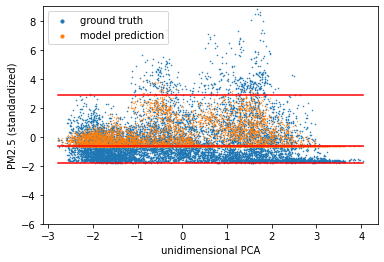

Absolute error - validation 0.46862107515335083
R2 - validation 0.3815233970686479
Absolute error - test 0.8721117973327637
R2 - test 0.39245260452383934


In [ ]:
# plot_and_evaluate_model_UNcensored(CHECKPOINT_MAE, t.nn.L1Loss, isGrid = False)
plot_and_evaluate_model_UNcensored(CHECKPOINT_MAE, t.nn.L1Loss, isGrid = True)

In [ ]:
# grid_results = t.load(GRID_RESULTS_FILE)
# best_config = grid_results['best']
# best_metrics = grid_results[str(best_config)]
# print(best_config)
# print(best_metrics)

# Bounded MAE

In [ ]:
def bounded_loss(y_pred, y):
  y_pred = t.clamp(y_pred, min = bound_min, max = bound_max)
  return mae(y_pred, y)

### Learning Rate Range Test

In [ ]:
# lr_range_test_UNcensored(lambda: bounded_loss, batch_size = 100, epochs = 1, start_lr = 1e-2, end_lr = 1e-1, log_view = False, plt_file_name = 'bounded_mae')

### Grid Search

In [ ]:
train_and_evaluate_net = train_and_evaluate_UNcensored(CHECKPOINT_BOUNDED_MAE, lambda: bounded_loss, plot = False, log = False)

In [ ]:
# conf = {
#     'max_lr': 5e-3,
#     'epochs': 10,
#     'batch': 100,
#     'pct_start': 0.3,
#     'anneal_strategy': 'linear',
#     'base_momentum': 0.85,
#     'max_momentum': 0.95,
#     'div_factor': 5,
#     'final_div_factor': 1e4,
#     'weight_decay': 0
# }
# train_and_evaluate_net(conf)

In [ ]:
# grid_config = [{
#     'max_lr': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3],
#     'epochs': [10, 20],
#     'batch': [100, 200],
#     'pct_start': [0.45],
#     'anneal_strategy': ['linear'],
#     'base_momentum': [0.85],
#     'max_momentum': [0.95],
#     'div_factor': [10, 5, 2],
#     'final_div_factor': [1e4],
#     'weight_decay': [0]
# }]
# grid_best = grid_search(grid_config, train_and_evaluate_net, CHECKPOINT_BOUNDED_MAE, conf_validation = config_validation)

In [ ]:
# grid_results = t.load(GRID_RESULTS_FILE)
# best_config = grid_results['best']
# best_metrics = grid_results[str(best_config)]
# print(best_config)
# print(best_metrics)

In [ ]:
# plot_and_evaluate_model_UNcensored(CHECKPOINT_BOUNDED_MAE, lambda: bounded_loss, isGrid = False)
# plot_and_evaluate_model_UNcensored(CHECKPOINT_BOUNDED_MAE, lambda: bounded_loss, isGrid = True)

# Bounded MAE With Penalty

In [ ]:
def bounded_loss_with_penalty(y_pred, y):
  return bounded_loss(y_pred, y) + below_zero_mae_penalty(y_pred)

### Learning Rate Range Test

In [ ]:
# lr_range_test_UNcensored(lambda: bounded_loss_with_penalty, batch_size = 100, epochs = 1, start_lr = 1e-2, end_lr = 1e-1, log_view = False, plt_file_name = 'bounded_mae')

### Grid Search

In [ ]:
train_and_evaluate_net = train_and_evaluate_UNcensored(CHECKPOINT_BOUNDED_MAE_WITH_PENALTY, lambda: bounded_loss_with_penalty, plot = False, log = False)

In [ ]:
# conf = {
#     'max_lr': 5e-3,
#     'epochs': 10,
#     'batch': 100,
#     'pct_start': 0.3,
#     'anneal_strategy': 'linear',
#     'base_momentum': 0.85,
#     'max_momentum': 0.95,
#     'div_factor': 5,
#     'final_div_factor': 1e4,
#     'weight_decay': 0
# }
# train_and_evaluate_net(conf)

In [ ]:
# grid_config = [{
#     'max_lr': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3],
#     'epochs': [10, 20],
#     'batch': [100, 200],
#     'pct_start': [0.45],
#     'anneal_strategy': ['linear'],
#     'base_momentum': [0.85],
#     'max_momentum': [0.95],
#     'div_factor': [10, 5, 2],
#     'final_div_factor': [1e4],
#     'weight_decay': [0]
# }]
# grid_best = grid_search(grid_config, train_and_evaluate_net, CHECKPOINT_BOUNDED_MAE_WITH_PENALTY, conf_validation = config_validation)

In [ ]:
# plot_and_evaluate_model_UNcensored(CHECKPOINT_BOUNDED_MAE_WITH_PENALTY, lambda: bounded_loss_with_penalty, isGrid = False)
# plot_and_evaluate_model_UNcensored(CHECKPOINT_BOUNDED_MAE_WITH_PENALTY, lambda: bounded_loss_with_penalty, isGrid = True)

In [ ]:
# grid_results = t.load(GRID_RESULTS_FILE)
# best_config = grid_results['best']
# best_metrics = grid_results[str(best_config)]
# print(best_config)
# print(best_metrics)